# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


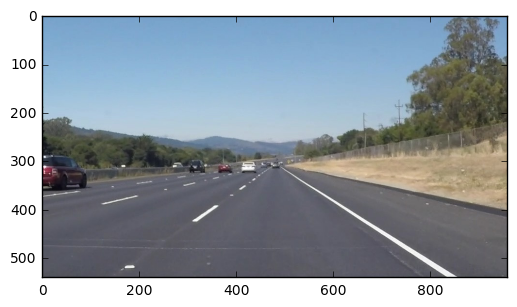

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [15]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Blur kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if len(img.shape) == 2:  # grayscale image -> make a "color" image out of it
        img = np.dstack((img, img, img))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha=0.8, beta=1., lamda=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lamda)

## Pipeline implementation
In this cell, we implement the image processing pipeline, taking as input the original image and output an annotated image, i.e. the original image with the detected lines drawn on top.

In [43]:
def rgb_to_hsv(img):
    """ Converts an RGB image to a HSV image"""    
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def show_img(img):
    """ Displays an image, no matter if it is RGB or single channel"""
    if len(img.shape) > 2:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

def preprocess(img):
    """ Preprocess the input image """
    # Convert to HSV and get value (luminance) channel, in order to make
    # our algorithm less sensitive to color.
    hsv = rgb_to_hsv(img)
    v = hsv[:,:,2]
    
    # Apply Gaussian Blur to reduce the noise in edge detection
    kernel_size = 5
    out = gaussian_blur(v, kernel_size)   
    
    #plt.subplot(2,2,1)
    #show_img(out)
    return out

def apply_canny(img):
    """ Applies the Canny edge detector to the input image """
    # Apply Canny edge detector
    low_threshold = 50
    high_threshold = 150
    
    out_img = canny(img, low_threshold, high_threshold)
    show_img(out_img)
    return out_img
    
def detect_lines(img):
    """ Runs the Hough transform to detect lines in the input image"""
    # Get edges using the Canny edge detector
    img_canny = apply_canny(img)
    
    # Mask out interest region
    h = 80
    k = 1.75
    v1 = (0+h, img.shape[0]) 
    v2 = (img.shape[1]/2 - 5, img.shape[0]/k) 
    v3 = (img.shape[1]/2 + 5, img.shape[0]/k) 
    v4 = (img.shape[1] - h, img.shape[0])
    img_canny = region_of_interest(img_canny, np.array([[v1, v2, v3, v4]], dtype=np.int32))
    
    #plt.subplot(2,2,2)
    #show_img(img_canny)
    
    # Apply HoughLines to extract lines
    rho_res         = 2                 # [pixels]
    theta_res       = np.pi/180.        # [radians]
    threshold       = 20                # [# votes]
    min_line_length = 30                # [pixels]
    max_line_gap    = 20                # [pixels]
    lines = cv2.HoughLinesP(img_canny, rho_res, theta_res, threshold, np.array([]), 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

def fitLine(line_points):
    """ Given 2 points (x1,y1,x2,y2), compute the line equation
    y = mx + b"""
    x1 = line_points[0]
    y1 = line_points[1]
    x2 = line_points[2]
    y2 = line_points[3]
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return (m, b)

def extract_lanemarkings(img_shape, lines):
    """ Given a list of lines (detected by the Hough transform),
    average and extrapolate them in order to come up with 2 single
    lines, corresponding to the left and right lanemarkings """
    # For each line segment
    slope_threshold = 1.0
  
    m1 = np.array([])
    b1 = np.array([])
    
    m2 = np.array([])
    b2 = np.array([])

    for line_points in lines:
        # Fit to line equation (m, b)
        (m, b) = fitLine(line_points)

        # Filter line by slope
        if abs(m) < slope_threshold:
            # Separate into left/right using the sign of the slope
            if (m > 0):
                m1 = np.append(m1, m)
                b1 = np.append(b1, b)
            else:
                m2 = np.append(m2, m)
                b2 = np.append(b2, b)
        
    # Average the two main lines
    m1 = np.mean(m1)
    b1 = np.mean(b1)
    
    m2 = np.mean(m2)
    b2 = np.mean(b2)
    
    # Compute the crossing (x,y) point in the image
    x_cross = (b2 - b1) / (m1 - m2)
    y_cross = m1 * x_cross + b1
    
    # Compute the (x) coordinate where the line crosses the 
    # bottom edge of the image
    y1 = img_shape[0]
    x1 = (y1 - b1) / m1
    y2 = img_shape[0]
    x2 = (img_shape[0] - b2) / m2    
    
    return np.array([[[x1, y1, x_cross, y_cross]], [[x2, y2, x_cross, y_cross]]]).astype(int)

def overlay_lanemarkings(img, lanemarkings):
    """ Draws the lines on top of the image img """
    # Create a black image with red lanemarkings
    img_lines = np.copy(img)*0
    draw_lines(img_lines, lanemarkings, color=[255, 0, 0], thickness=10)
    
    # Blend the original image with the previous one
    img_out = weighted_img(img_lines, img)
    return img_out

def pipeline(img_original):
    """
    Process the input image 'img' and outputs an annotated version of it,
    where the left and right lane markings are detected.
    """
    # Pre-process
    img = preprocess(img_original)
    
    # Detect lines
    lines = detect_lines(img)
    line_img = np.copy(img_original)
    draw_lines(line_img, lines)    
    #plt.subplot(2,2,3)
    #show_img(line_img)
    
    # Extract left and right lanemarkings from the lines
    lanemarkings = extract_lanemarkings(img.shape, lines.squeeze())
    
    # Produce output
    img_out = overlay_lanemarkings(img_original, lanemarkings)
    return img_out

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [25]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

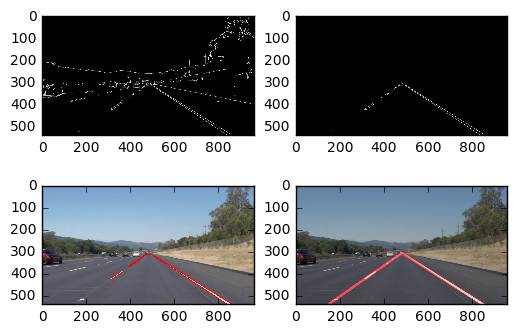

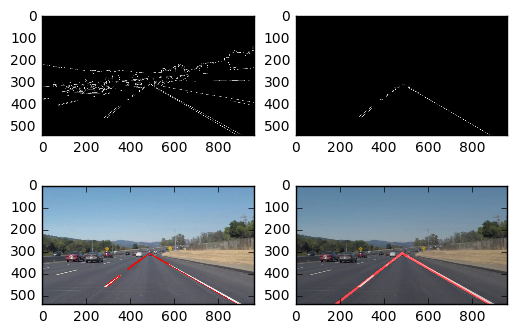

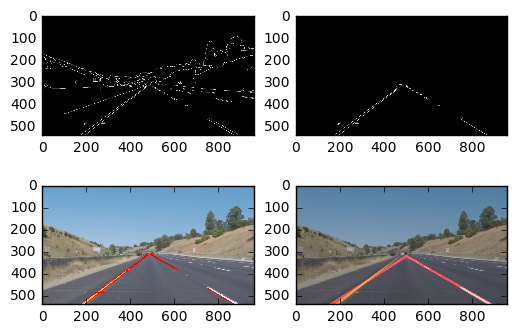

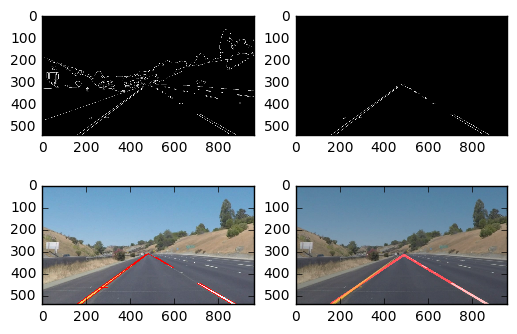

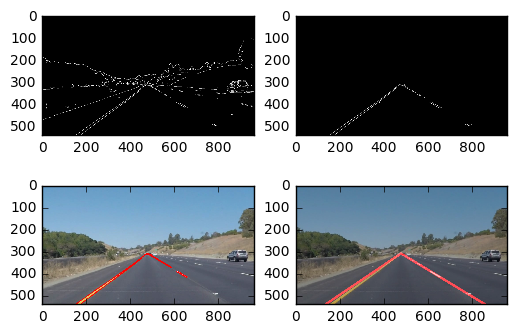

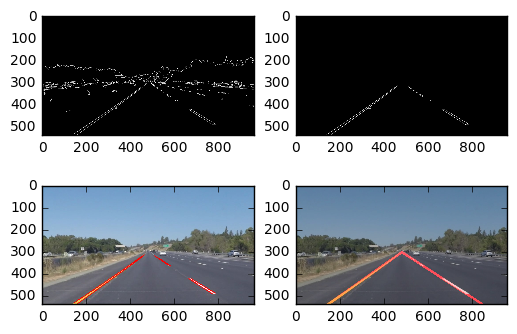

In [36]:
test_images = os.listdir("test_images/")

for i in range(0, len(test_images)):
    plt.figure(i + 1)
    img = mpimg.imread(os.path.join("test_images",test_images[i]))
    pipeline(img)
        

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0%)434176/28549024 bytes (1.5%)786432/28549024 bytes (2.8%)1236992/28549024 bytes (4.3%)1654784/28549024 bytes (5.8%)2023424/28549024 bytes (7.1%)2465792/28549024 bytes (8.6%)2793472/28549024 bytes (9.8%)3235840/28549024 bytes (11.3%)3678208/28549024 bytes (12.9%)4038656/28549024 bytes (14.1%)4448256/28549024 bytes (15.6%)4816896/28549024 bytes (16.9%)5169152/28549024 bytes (18.1%)

In [44]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  2%|▏         | 5/222 [00:00<00:05, 42.14it/s]



  5%|▍         | 10/222 [00:00<00:05, 42.13it/s]



  6%|▋         | 14/222 [00:00<00:05, 40.45it/s]



  9%|▊         | 19/222 [00:00<00:04, 40.71it/s]



 10%|█         | 23/222 [00:00<00:05, 39.73it/s]



 13%|█▎        | 28/222 [00:00<00:04, 40.31it/s]



 14%|█▍        | 32/222 [00:00<00:04, 38.94it/s]



 16%|█▌        | 36/222 [00:00<00:04, 38.71it/s]



 18%|█▊        | 40/222 [00:01<00:04, 38.00it/s]



 20%|█▉        | 44/222 [00:01<00:05, 35.22it/s]



 22%|██▏       | 48/222 [00:01<00:05, 31.82it/s]



 23%|██▎       | 52/222 [00:01<00:05, 32.09it/s]



 25%|██▌       | 56/222 [00:01<00:05, 29.60it/s]



 27%|██▋       | 60/222 [00:01<00:06, 23.24it/s]



 28%|██▊       | 63/222 [00:02<00:11, 14.42it/s]



 30%|██▉       | 66/222 [00:02<00:09, 15.98it/s]



 31%|███       | 69/222 [00:02<00:10, 15.08it/s]



 32%|███▏      | 72/222 [00:02<00:09, 16.55it/s]



 34%|███▍      | 7

OverflowError: signed integer is less than minimum

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]


  0%|          | 1/682 [00:00<01:17,  8.79it/s]


  0%|          | 3/682 [00:00<01:11,  9.55it/s]


  1%|          | 5/682 [00:00<01:08,  9.92it/s]


  1%|          | 7/682 [00:00<01:04, 10.48it/s]


  1%|▏         | 9/682 [00:00<01:02, 10.81it/s]


  2%|▏         | 11/682 [00:00<01:00, 11.16it/s]


  2%|▏         | 13/682 [00:01<00:58, 11.40it/s]


  2%|▏         | 15/682 [00:01<00:58, 11.39it/s]


  2%|▏         | 17/682 [00:01<00:58, 11.40it/s]


  3%|▎         | 19/682 [00:01<00:57, 11.50it/s]


  3%|▎         | 21/682 [00:01<00:56, 11.70it/s]


  3%|▎         | 23/682 [00:02<00:57, 11.45it/s]


  4%|▎         | 25/682 [00:02<01:05, 10.10it/s]


  4%|▍         | 27/682 [00:02<01:03, 10.36it/s]


  4%|▍         | 29/682 [00:02<01:01, 10.67it/s]


  5%|▍         | 31/682 [00:02<01:19,  8.22it/s]


  5%|▍         | 32/682 [00:03<01:19,  8.18it/s]


  5%|▍         | 34/682 [00:03<01:20,  8.08it/s]


  5%|▌         | 36/682 [00:03<01:12,  8.8

OverflowError: signed integer is less than minimum

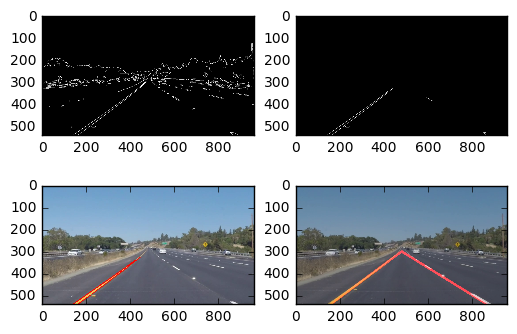




  6%|▌         | 42/682 [00:22<05:41,  1.87it/s]

In [42]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

---
Here we have implemented a very simple algorithm to detect the lanemarkings in the road using standard image processing techniques. However there are a few aspects that could be improved or that can potentially make the algorithm fail:

-**Curved lanemarkings**. Right now we are trying to fit the edge pixels to a linear model of the lanemarking. However this assumption does not hold for curved roads. The output from the Hough detector would be a piecewise-linear lanemarking. However we would need to be able to determine which sub-lines belong to the same lanemarking.
A better approach would be to parametrice the lanemarking as a quadratic curve or a Bézier curve. This would however require extending the Hough space to more dimensions (one per extra parameter), which would exponentially increase the computation time.

-**Light/road conditions**. It is likely that the code will perform worse under non-ideal lightning conditions. For example, with shadows or reflections on the road (e.g. with rain), which would make the edges be not so clear to the Canny detector.

-**Too many parameters**. The code is quite tailor-made for this application, with a lot of tuning parameters: region of interest (ROI), Canny and Hough parameters, etc. This makes the algorithm very sensitive to different inputs. It would be better if these paremeters could be learnt from a large amount of training data.

-**Centered-vehicle assumption**. The region of interest (ROI) assumes that the vehicle is somewhat centered in the lane. This allows us to discard a big portion of the image and focus on extracting lines only where required. This provides a good performance but will make the algorithm fail if the vehicle is not well centered or if we are executing a lane change.


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))